# Milestone Project 0
### The Data Incubator Bootcamp
### Sasha Berkoff, Sept 18, 2022

In this project, we were asked to download the <a href="https://data.cityofnewyork.us/City-Government/Value-of-Energy-Cost-Savings-Program-Savings-for-B/bug8-9f3g">Value of Energy Cost Savings Program Savings for Businesses</a> from the New York City OpenData website and do some preliminary analysis.

The <a href="https://www1.nyc.gov/nycbusiness/description/energy-cost-savings-program">ECSP</a> is a program that offers lower energy prices to businesses the government of NYC wants to attract or retain. Businesses that apply and are eligible get up to 45% off their energy bills for 8 years, followed by a phase out of those benefits for 4 more years, for a total of 12 years in the program.

# Setup
To start with, we import the python packages we'll need to read/analyze/display data from this source.

In [214]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from datetime import date

# brokenaxes package: https://github.com/bendichter/brokenaxes
from brokenaxes import brokenaxes

Then, we'll import the dataset and save it in a Pandas dataframe called `ecsp`.

In [90]:
# from the nyc opendata website, we know that col 14 contains dates, 
# so we'll make sure to parse them as dates
ecsp = pd.read_csv("datasets/Value_of_Energy_Cost_Savings_Program_Savings_for_Businesses_-_FY2020.csv", 
                   parse_dates =[14])

Next, we take a first look at the data, just as a check that we imported it correctly! 

In [91]:
# Note that there are 26 columns, and we want to see all of them
with pd.option_context('display.max_columns', None): 
    display(ecsp[1:10])

,Company Name,company contact,company email,company phone,Address,City,State,Postcode,Industry,Industry descr,Company Type,Current fulltime,Job created,Job retain,Effective Date,Total Savings,Savings from beginning receiving benefits,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
1,100 Church LLC,Edward A. Carroll,NaN,2125663000,100 Church Street,NY,NY,10007,Commercial,21 Floors,LMEP,NaN,NaN,NaN,2008-04-02,136578.20,4423698.05,New York,40.712968,-74.009490,101.0,1.0,21.0,1001409.0,1.001250e+09,SoHo-TriBeCa-Civic Center-Little Italy
2,100 Wall Investments,Jerry Branam,NaN,2122487160,96 Wall Street,New York,NY,10005,Landlord,NaN,LMEP,1238.0,NaN,NaN,2015-01-05,302959.40,1814542.62,New York,40.705052,-74.007199,101.0,1.0,7.0,1000875.0,1.000380e+09,Battery Park City-Lower Manhattan
3,1-10 Bush Terminal Owner LP,Andrew Kimball,akimball@industrycity.com,3474178429,"220 36th St, Suite 2A",Brooklyn,NY,11232,Landlord,Special Eligible Premises for eligible businesses,ECSP,25.0,NaN,NaN,2020-02-03,2159.67,6755.31,Brooklyn,40.656061,-74.007334,307.0,38.0,2.0,3398687.0,3.006950e+09,Sunset Park West
4,"120 Broadway Acquisitions JV, LLC (Ldmk)",Carl Letich,clettich@silvprop.com,2124064020,120 Broadway,New York,NY,10271,Commercial,NaN,LMEP,2699.0,NaN,NaN,2017-06-30,922407.32,3293055.08,New York,40.708546,-74.011041,101.0,1.0,7.0,1001026.0,1.000478e+09,Battery Park City-Lower Manhattan
5,"120 Wall Street, LLC",Jason McCalla,jmccalla@silvprop.com,2125517391,120 Wall Street,New York,NY,10005,Commercial,Back Offices,LMEP,958.0,NaN,NaN,2015-07-02,368601.17,2090906.36,New York,40.704380,-74.006427,101.0,1.0,7.0,1000871.0,1.000370e+09,Battery Park City-Lower Manhattan
6,"139 ACA Realty, Inc.",Eitan Chandally,barbara@dial7.com,7187076123,43-23 35th Street,Long Island City,NY,11101,Commercial,Limousine Service,ECSP,125.0,NaN,NaN,2008-04-07,1637.29,129401.39,Queens,40.745706,-73.929565,402.0,26.0,179.0,4003160.0,4.002220e+09,Hunters Point-Sunnyside-West Maspeth
7,"141 Lake Avenue Realty c/o JR Produce, Inc.",Josef Raz,jrproduce@gmail.com,7183708782,141 Lake Avenue,Staten Island,NY,10303,Wholesale/Warehouse/Distribution,Dist. of prepacked salads,ECSP,6.0,NaN,NaN,2009-12-08,4380.51,59681.70,Staten Island,40.633153,-74.150999,501.0,49.0,239.0,5146740.0,5.011610e+09,Mariner's Harbor-Arlington-Port Ivory-Granitev...
8,14-10 123rd Street LLC,Danica/Ivan Drazic,ddrazic@atjelectrical.com,7183210117,14-10 123rd Street,College Point,NY,11356,Commercial,Electrical Parts Mfg.,ECSP,35.0,NaN,NaN,2011-03-04,2534.00,28752.48,Queens,40.785144,-73.844833,407.0,19.0,929.0,4098344.0,4.040850e+09,College Point
9,183 Lorriane Street LLC,Tom Sapienza,tsapienza@KLCNY.com,2128405588,183 Lorraine Street,Brooklyn,NY,11231,Wholesale/Warehouse/Distribution,Commercial Storage facility,ECSP,9.0,NaN,NaN,2015-11-06,31483.87,187637.74,Brooklyn,40.673106,-74.002300,306.0,38.0,53.0,3336622.0,3.005720e+09,Carroll Gardens-Columbia Street-Red Hook


Then, we verify some basic info about our dataframe: namely, the names of the column headers, and the data types for each column.

In [5]:
# notice that ecsp["Effective Date"] is contains datetimes!
ecsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Company Name                               450 non-null    object        
 1   company contact                            450 non-null    object        
 2   company email                              433 non-null    object        
 3   company phone                              450 non-null    object        
 4   Address                                    450 non-null    object        
 5   City                                       450 non-null    object        
 6   State                                      450 non-null    object        
 7   Postcode                                   450 non-null    int64         
 8   Industry                                   450 non-null    object        
 9   Industry descr       

## Question 1.1: How Many Companies are in the Dataset?
We know our table has 450 rows, so our goal is to find out which of those rows are duplicates.  

Presumably two rows with the same value for `"Company Name"` refer to the same company, but what if there are two rows whose company names slightly differ (say, because of a typo), but still represent the same business? In that case, they probably have the same address or phone number. So we group the rows by phone number and look at the company names, contact person, address, and effective date for rows that share the same phone number.  Here are the first few entries:

In [81]:
relevant_headers = ["Company Name", "company contact", "company phone", 
                    "Address", "City", "Borough", "State", "Postcode", "NTA"]

ecsp.groupby("company phone").filter(lambda x: len(x) > 1)[relevant_headers][0:11]

,Company Name,company contact,company phone,Address,City,Borough,State,Postcode,NTA
0,1 State Street,David Neiburg,7186779077,1114 Avenue J,Brooklyn,Brooklyn,NY,11230,Midwood
9,183 Lorriane Street LLC,Tom Sapienza,2128405588,183 Lorraine Street,Brooklyn,Brooklyn,NY,11231,Carroll Gardens-Columbia Street-Red Hook
13,25 Broadway (Ldmk),David Neiburg,7186779077,1114 Avenue J,Brooklyn,Brooklyn,NY,11230,Midwood
18,75 Broad Street,David Neiburg,7186779077,1114 Ave J,Brooklyn,Brooklyn,NY,11230,Midwood
33,Albert Einstein College of Medicine R&D,Jack Zencheck,7184308977,1196 Pierce Avenue,Bronx,Bronx,NY,10461,Van Nest-Morris Park-Westchester Square
34,Albert Einstein College of Medicine R&D,Jack Zencheck,7184308977,1196 Pierce Avenue,Bronx,Bronx,NY,10461,Van Nest-Morris Park-Westchester Square
160,FEDERAL EXPRESS,Samuel Adamson,7187886000,830 Fountain Avenue,Brooklyn,Brooklyn,NY,11239,East New York
161,FEDERAL EXPRESS,Samuel Adamson,7187886000,830 Fountain Avenue,Brooklyn,Brooklyn,NY,11239,East New York
162,FEDERAL EXPRESS,Samuel Adamson,7187886000,830 Fountain Avenue,Brooklyn,Brooklyn,NY,11239,East New York
171,FRESH DIRECT LLC,JOE LACY,2128222203,23-30 BORDEN AVENUE,Queens,Queens,NY,11101,Hunters Point-Sunnyside-West Maspeth


<b>Conclusion:</b> Two rows can share the same contact, phone number, and address but still refer to different companies, as one person might be the contact for several different companies. However, luckily, in cases where two rows _look_ like they are for the same business, their `Company Name` values are identical. Thus, it's sufficient to count the number of unique company names, as we do below.

In [25]:
print("Number of unique companies:", ecsp["Company Name"].nunique())

Number of unique companies: 439


## Question 1.2: Number of Jobs created in Queens.

Next, we're asked to find out the number of jobs created in Queens. From `ecsp.info()` we knowthat only 11 rows had non-null values for `"Job Created"` so first, just take a look at those rows and save that view as `job_creators`.

In [41]:
job_creators= ecsp.dropna(subset=["Job created"])
job_creators[["Company Name", "Address", "City", "State", "Postcode", "Borough", "Job created"]]

,Company Name,Address,City,State,Postcode,Borough,Job created
29,"AFC INDUSTRIES, INC.",13-16 133RD PLACE,College Point,NY,11356,Queens,10.0
37,ALLE PROCESSING CORP.,54-58 56TH DR. & 5820-5880 MAURICE,Queens,NY,11378,Queens,60.0
95,"CARNEGIE LINEN SERVICES, INC.",874 EAST 139TH STREET,Bronx,NY,10454,Bronx,5.0
120,DAIRYLAND USA CORP.,240 FOOD CENTER DRIVE,Bronx,NY,10474,Bronx,12.0
137,"DURA FOAM, INC.",63-02 59TH AVENUE,Queens,NY,11378,Queens,10.0
324,"PEPSI COLA BOTTLING CO., OF NY",112-02 15TH AVENUE,College Point,NY,11356,Queens,2.0
353,"RUGUS REALTY, INC. DBA MISS GRIMBLE",909 EAST 135TH STREET,Bronx,NY,10454,Bronx,2.0
414,ULTRA CREATIVE CORP.,957 ESSEX STREET,Brooklyn,NY,11208,Brooklyn,15.0
432,"WALDORF BAKERY, INC. DBA MAURICE",909 EAST 135TH STREET,bronx,NY,10454,Bronx,3.0
433,"WATER LILIES FOOD, INC.",45-10 19TH AVENUE,Queens,NY,11105,Queens,20.0


Inspecting these rows, we see that whenever the `Borough` column contains the value __Queens__ the `City` column either contains __Queens__ or __College Point__, which is a neighborhood of Queens. So it's sufficient to just take the group of rows whose `Borough` is __Queens__ and calculate the sum of the jobs created.

In [42]:
by_borough = job_creators.groupby("Borough")
print("Jobs created in Queens:")
print(by_borough.get_group("Queens")["Job created"].sum())

Jobs created in Queens:
102.0


## Question 1.3: How many unique email domains?

An email domain is the part of an email address that comes after the _@_ sign. So to find the number of unique email domains in our data set, we just look at the list of all email addresses, split them on the `'@'` character, and look at the substrings after the _@_ sign. Since we don't care about capitalization, we'll cast all those substrings to lower case and then count the number of unique ones.

In [43]:
emails = ecsp[["company email"]].dropna()

# split list of emails into antecedent (part before @) and domain (part after @)
emails[["antecedent", "domain"]] = emails["company email"].str.split('@', expand=True)

# count number of email domains (after making them all lower case)
print("number of unique email domains: ", emails["domain"].str.lower().nunique())

number of unique email domains:  356


## Questions 1.4, 1.5: Group by NTA
In this question, we're asked to identify all NTAs with more than five businesses in them and find out the total number of jobs they've created and their average total savings. (I interpreted this to mean "average total savings in FY2020", meaning we want values from the `Total Savings` column, not the `Savings from Beginning of Receiving Benefits` column.)

### What if we don't know a business's NTA?
We know from `ecsp.info()` that 41 of the rows in our table don't have NTAs associated with them. An NTA is a "Neighborhood Tabulation Area," so here's a sample of the location information we _do_ know about the businesses without listed NTAs:

In [45]:
ecsp[ecsp['NTA'].isna()][["Company Name", "Address", "Borough", "City", "State", "Postcode"]][1:10]

,Company Name,Address,Borough,City,State,Postcode
32,"ALADDIN BAKERS, INC/Bread Head, LLC.",236-238 25TH STREET,New York,New York,NY,11232
37,ALLE PROCESSING CORP.,54-58 56TH DR. & 5820-5880 MAURICE,Queens,Queens,NY,11378
56,"Asymptote Architecture, PLLC",1145-46 AVE,Queens,Queens,NY,11101
59,B.P. AIR CONDITIONING CORP/,84-00 73RD ST.,Queens,QUEENS,NY,11385
75,BILLIE-ANN PLASTICS PKGING CORP,360 AND 372 TROUTMAN STREET,Brooklyn,Brooklyn,NY,11237
85,"Bronx Westchester Tempering, Inc",160 South MacQuesten Pkwy,Bronx,Bronx,NY,10550
88,BROOKLYN UNION GAS COMPANY,Keyspan Energy Delivery,Brooklyn,Brooklyn,NY,11236
94,"Carlton House Restoration, Inc.",18-20 Dacatur Street,Queens,Ridgewood,NY,11385
102,"Citibank, N.A.",ONE COURT SQUARE/ 25-01 JACKSON AVE,Queens,Queens,NY,11120


If you try checking the above companies by hand in the [NYC Population Fact Finder](https://popfactfinder.planning.nyc.gov/#11.67/40.7198/-73.9515) (a website that lets you search which NTA a given address is located in) you find that some of the addresses are ambiguous. For example, depending on whether Aladdin Bakers is on East or West 25th St, and whether it's in Manhattan or Brooklyn, it could be in any of four different NTAs. Thus, we can't easily find the missing NTAs, so we'll drop those businesses from our calculations.

### How to handle Duplicates?
Below is a list of companies that are duplicated in our table. As seen below, none of them have any jobs listed, but they have different amounts listed for Total Savings. Additionally, they are not strictly increasing or decreasing when sorted by "Effective Date", which means there's no reason to assume the latest (or the earliest) number is the most correct one. I chose to sum the total savings for each duplicated business under the assumption that each row of the table might represent a different part of the company, I think choosing the max value would also be reasonable, as would dropping rows with duplicate names.

In [129]:
ecsp[ecsp.duplicated(["Company Name"], keep=False)][["Company Name", "NTA", 
                                                     "Effective Date", "Job created", 
                                                     "Total Savings"]].groupby(["Company Name", "Effective Date"]).sum(min_count=1)


Job created  \
Company Name                            Effective Date                
Albert Einstein College of Medicine R&D 2015-07-02              NaN   
                                        2020-02-18              NaN   
FEDERAL EXPRESS                         2007-07-05              NaN   
                                        2008-09-09              NaN   
                                        2015-07-08              NaN   
FRESH DIRECT LLC                        2010-10-05              NaN   
                                        2017-08-08              NaN   
JetBlue Airways, Corp.                  2013-06-04              NaN   
                                        2013-12-04              NaN   
KEPCO, INC.                             2008-01-31              NaN   
MEDITERRANEAN GYRO PRODUCTS             2011-11-01              NaN   
                                        2014-08-04              NaN   
Magellan Aerospace New York, Inc        2005-06-30              NaN   
                                        2017-06-29              NaN   
Montefiore Medical Center               2010-06-02              NaN   
                                        2016-07-01              NaN   
SILVERCUP Services LLC                  2008-05-06              NaN   
                                        2016-10-07              NaN   
Spin Master, Inc.                       2019-11-04              NaN   
                                        2020-07-07              NaN   

                                                        Total Savings  
Company Name                            Effective Date                 
Albert Einstein College of Medicine R&D 2015-07-02          985418.13  
                                        2020-02-18           75096.36  
FEDERAL EXPRESS                         2007-07-05             867.85  
                                        2008-09-09            9210.43  
                                        2015-07-08           64896.54  
FRESH DIRECT LLC                        2010-10-05           33328.86  
                                        2017-08-08          740244.55  
JetBlue Airways, Corp.                  2013-06-04           57634.59  
                                        2013-12-04          759480.44  
KEPCO, INC.                             2008-01-31            7536.14  
MEDITERRANEAN GYRO PRODUCTS             2011-11-01            8716.98  
                                        2014-08-04            7149.50  
Magellan Aerospace New York, Inc        2005-06-30           40896.53  
                                        2017-06-29            3561.17  
Montefiore Medical Center               2010-06-02          498728.81  
                                        2016-07-01          143273.55  
SILVERCUP Services LLC                  2008-05-06           22395.81  
                                        2016-10-07           39801.68  
Spin Master, Inc.                       2019-11-04            3497.94  
                                        2020-07-07             172.82

So first we gather the companies by their NTAs and combine duplicate companies as explained above.

In [139]:
unique_company_groups = ecsp.groupby(by=["NTA", "Company Name"])
by_nta = unique_company_groups.agg({'Job created':lambda x: x.sum(skipna=False), 'Total Savings':'sum'})

Then we get rid of all the NTAs without enough companies.

In [140]:
# get a dataframe of the companies in NTAs where the NTA has >= 5 unique companies
big_ntas = by_nta.groupby(level=0).filter(lambda x: len(x) >= 5)

Finally, we get the average total savings and number of jobs created for each NTA that's left.

In [141]:
big_ntas_stats=big_ntas.groupby("NTA").agg(
    **{"Average Total Savings":pd.NamedAgg(column="Total Savings", aggfunc="mean"),
       "Total Reported Jobs Created":pd.NamedAgg(column="Job created", aggfunc="sum"),
       "Num who Reported Jobs":pd.NamedAgg(column="Job created", aggfunc="count"),
       "Num Companies":pd.NamedAgg(column="Total Savings", aggfunc="count")
    }
)
big_ntas_stats.style.format({'Average Total Savings': '${0:,.2f}', 'Total Reported Jobs Created': '{}'})

,Average Total Savings,Total Reported Jobs Created,Num who Reported Jobs,Num Companies
NTA,,,,
Battery Park City-Lower Manhattan,"$469,890.80",0.0,0,9
Bushwick South,"$26,140.45",10.0,1,10
Carroll Gardens-Columbia Street-Red Hook,"$24,337.39",0.0,0,11
College Point,"$17,159.37",2.0,1,7
Crown Heights North,"$4,036.30",0.0,0,9
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,"$59,950.34",0.0,0,10
East New York,"$62,271.12",15.0,1,7
East Williamsburg,"$13,990.63",0.0,0,11
Greenpoint,"$9,753.65",0.0,0,14


Finally, we save that data to ECSP_stats.csv

In [142]:
filepath = "datasets/ECSP_stats.csv"
big_ntas_stats.to_csv(filepath)

## Question 2.1: Jobs Created vs. Average Total Savings
Next, we read in the CSV we created and start making visualizations. First up is a scatter plot of average savings vs. number of jobs created in both a linear and logarithmic scale.

In [143]:
df = pd.read_csv("datasets/ECSP_stats.csv")

Since so few companies reported _anything_ about the number of jobs they created, many of the NTAs are listed as having created 0 jobs. On the one hand, it might make sense to leave these NTAs out of the scatter plots, since we don't know if they created jobs or not. On the other hand, even in NTAs that have a non-zero number of jobs created, many of their businesses did not report anything, and it seems arbitrary to rule out NTAs where say, 0 out of 9 companies reported Jobs Created, but leave in ones where 1 out of 10 companies reported Jobs Created. As a compromise, I left all the NTAs on the scatter plot, but visually indicated the fraction of their businesses that even reported jobs numbers, as described in the colorbar.

In [144]:
df["Fraction who Reported Jobs"] = df["Num who Reported Jobs"]/df["Num Companies"]

In [146]:
jobs_created = df["Total Reported Jobs Created"]
avg_savings = df["Average Total Savings"]
fraction_reporting = df["Fraction who Reported Jobs"]
ntas = df["NTA"]

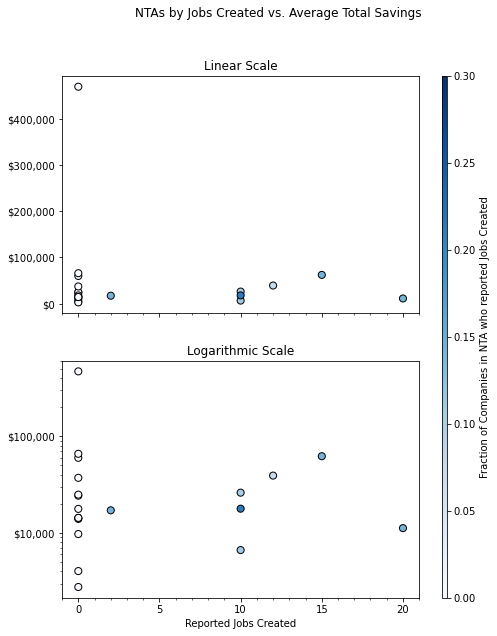

In [208]:
fig1, axs = plt.subplots(2, sharex=True, figsize=[8, 9.6])
lin_scatter=axs[0]
log_scatter=axs[1]
#title of both plots
fig1.suptitle("NTAs by Jobs Created vs. Average Total Savings")

# major tick every 5 jobs, minor tick every 1 job
lin_scatter.xaxis.set_major_locator(ticker.MultipleLocator(5))
lin_scatter.xaxis.set_minor_locator(ticker.MultipleLocator(1))

lin_scatter.set_title("Linear Scale")
lin_scatter.scatter(jobs_created, avg_savings, 
                    c=fraction_reporting, cmap='Blues', vmin=0, vmax=.3, 
                    edgecolor='black',
                    s=50)

# display dollars with dollar sign and commas
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
lin_scatter.yaxis.set_major_formatter(tick) 

log_scatter.set_yscale('log')
log_scatter.set_title("Logarithmic Scale")
log_scatter.scatter(jobs_created, avg_savings, 
                    c=fraction_reporting, cmap="Blues", vmin = 0, vmax = .3,
                    edgecolor='black',
                    s=50)

# display dollars with dollar sign and commas
log_scatter.yaxis.set_major_formatter(tick)
log_scatter.set_xlabel("Reported Jobs Created")

# add color bar
cmap = "Blues"
norm = mp.colors.Normalize(vmin=0, vmax=.3)
plt.colorbar(mp.cm.ScalarMappable(norm=norm, cmap=cmap), 
             ax=axs.ravel(), 
             label="Fraction of Companies in NTA who reported Jobs Created",
             aspect=100
            )


## Question 2.2 Histogram of Average Total Savings
Next, we plot a histogram of the average total savings per NTA on a log scale. I chose to divide the average total savings into 10 buckets. Note that because we're using a log-scale, we need to scale our buckets on a log scale too.

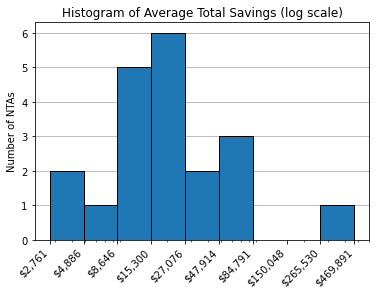

In [211]:
hist = plt.subplot()
hist.set_title("Histogram of Average Total Savings (log scale)")
hist.set_ylabel("Number of NTAs")
hist.set_xscale('log')
hist.grid(axis="y")
# we want the bins to be divided up on a logarithmic scale, not linear
logbins = np.geomspace(avg_savings.min(), avg_savings.max(), 10)

# zorder=2 makes the histogram bars show up in front of the horizontal lines
hist.hist(avg_savings, bins=logbins, edgecolor='black', zorder=2)
hist.xaxis.set_major_formatter(tick)
hist.set_xticks(logbins.round())

# rotate the labels on the bottom axis 
for label in hist.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')


## Question 2.3 Line Plot of Jobs Created by Month
Finally, we were asked to make a line plot of jobs created by month. This is a weird question as the only dates present in our dataset are "Effective Date" which I interpret as "Date the company entered the ECSP" and there's no reason to believe that date is the date at which jobs were created. Furthermore, as already discussed, only 11 companies in the whole dataset have entries for "Job Created," so even if they all have different Effective Dates, it's going to be a line graph that's 0 almost everywhere.

First, just in case two or more companies were created on the same "Effective Date," we sum the number of companies created on eah date.

In [213]:
grouped = job_creators.groupby("Effective Date")
jobs_created_timeseries = grouped["Job created"].sum()
jobs_created_timeseries

Effective Date
1993-02-05    15.0
2004-03-05    10.0
2005-02-03    12.0
2006-03-01    10.0
2007-04-10     2.0
2007-05-02     2.0
2007-06-08     3.0
2007-06-28    60.0
2007-07-02    20.0
2007-11-06     5.0
2008-12-09    10.0
Name: Job created, dtype: float64

Next, we resample our data so that we have a number of jobs created for each month over our time period.

In [216]:
jobs_by_month = jobs_created_timeseries.resample('M').sum()
jobs_by_month

Effective Date
1993-02-28    15.0
1993-03-31     0.0
1993-04-30     0.0
1993-05-31     0.0
1993-06-30     0.0
              ... 
2008-08-31     0.0
2008-09-30     0.0
2008-10-31     0.0
2008-11-30     0.0
2008-12-31    10.0
Freq: M, Name: Job created, Length: 191, dtype: float64

Finally, we plot our data. Since there's literally zero jobs created reported between March 1993 and Feb 2004, I found a python library called brokenaxes that allowed me to show a break in the x axis rather than display that entire decade of no data. Each small tick on the x axis below represents one month.

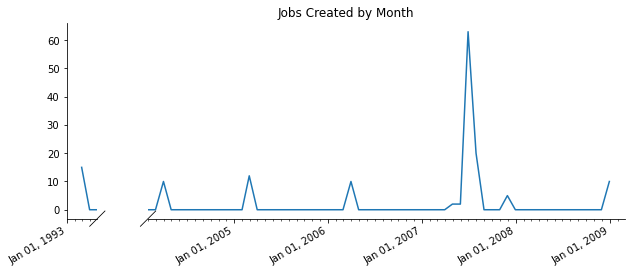

In [226]:
fig = plt.figure(figsize = (10,4))
bax = brokenaxes(
    xlims=(
        # left half of broken axis
        (
            datetime.date(1992, 12, 31),
            datetime.date(1993, 4, 30),
        ),
        # right half of broken axis
        (
            datetime.date(2004, 1, 31),
            datetime.date(2009, 2, 28),
        )
    )
)

bax.plot(jobs_by_month)
bax.set_title("Jobs Created by Month")

# write date on diagonal
fig.autofmt_xdate()

# remove the tick marks in the "broken" part of the axis
[x.remove() for x in bax.diag_handles]

# draw small diagonal lines on the axis to indicate that it's broken
bax.draw_diags()

import matplotlib.dates as mdates


for ax in bax.axs:
    # large ticks are years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    # small ticks are months
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # write date out with month, day and year as seen below
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))